# Introduction 

On the 18th of September 2017 a hurricane made landfall in Puerto Rico. Torrential rain and high winds caused extensive damage to infrastructure and led to widespread flooding https://en.wikipedia.org/wiki/Hurricane_Maria

In this tutorial we will use radar data provided by the European Space Agency Sentinel 1 Mission to identify flooded regions. We will do this using image segmentation and K-Means clustering. 

There are 3 preprocessed images, the first taken before the hurricane on 16/09/17, the second taken  just after the hurricane on 22/09/17 and the last taken one month after the hurricane on 22/10/17. ) 


In [1]:
# Import needed modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# Data pre processing

The instrument onboard the Sentinel-1 satellites transmits in one polarisation and measures in two. The first band in each data file is the signal measured in the same polarisation as the transmission and the second is measured in the opposite polarisation.

We define a function load_data to read data from the numpy arrays. 

We define a second function to calculate the surface polarisation and add this as a third acces. The surface polarisation is the ratio of polarisation in the first two bands. 

In [2]:
# Define some useful functions

def load_data(filename):
    im=np.load(filename)
    return im

def data_preprocess(data_array):
    processed_data=np.zeros(np.shape(data_array))
    processed_data[:,:,0]=data_array[:,:,0]
    processed_data[:,:,1]=data_array[:,:,1]
    processed_data[:,:,2]=data_array[:,:,0]/data_array[:,:,1]
    return processed_data

In [3]:
# Load in data

radar_data=glob.glob('data_1/SAR*npy')
day1=load_data(radar_data[0])
day2=load_data(radar_data[1])
day3=load_data(radar_data[2])

# Set third axis to be surface polarisation
day_1_preprocessed=data_preprocess(day1)
day_2_preprocessed=data_preprocess(day2)
day_3_preprocessed=data_preprocess(day3)


# Data Visualisation

Here we plot a subsection of the first day of data. We also define a subregion of the data that will be used for training the K-means clustering algorithm

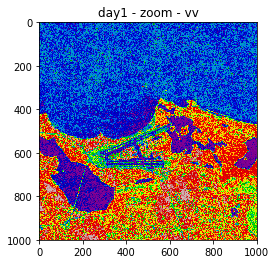

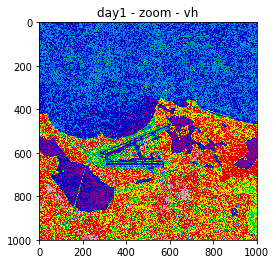

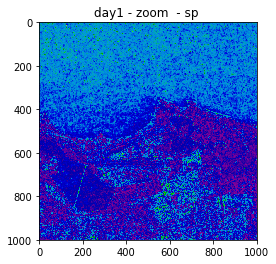

In [4]:
# Plot the first day of data
%matplotlib inline
#%matplotlib tk

plt.imshow(day_1_preprocessed[0:1000,2000:3000,0],'nipy_spectral')
plt.title('day1 - zoom - vv')
plt.show()

plt.imshow(day_1_preprocessed[0:1000,2000:3000,0],'nipy_spectral')
plt.title('day1 - zoom - vh')
plt.show()

plt.imshow(day_1_preprocessed[0:1000,2000:3000,2],'nipy_spectral')
plt.title('day1 - zoom  - sp ')
plt.show()


In [5]:
# Define subregions
day1_training=day_1_preprocessed[0:1000,2000:3000,:]
day1_test=day_1_preprocessed[400:1400,3300:4300,:]
day2_test=day_2_preprocessed[400:1400,3300:4300,:]
day3_test=day_3_preprocessed[400:1400,3300:4300,:]

# Image Segmentation

In the next section we use the segmetation module from scikit-image (http://scikit-image.org/docs/dev/api/skimage.segmentation.html) to create image segments. 
Each of these segments will be treated as a superpixel. We will calculate statiscs for each of the superpixels and use these as the input features for the K-means algorithm. 

The function calculate_segment_stats will calculate the minimum value, the maximum value, the mean, the variance, the skewness and the kurtosis of each super pixel for each band

** TODO Add in experiment thing **


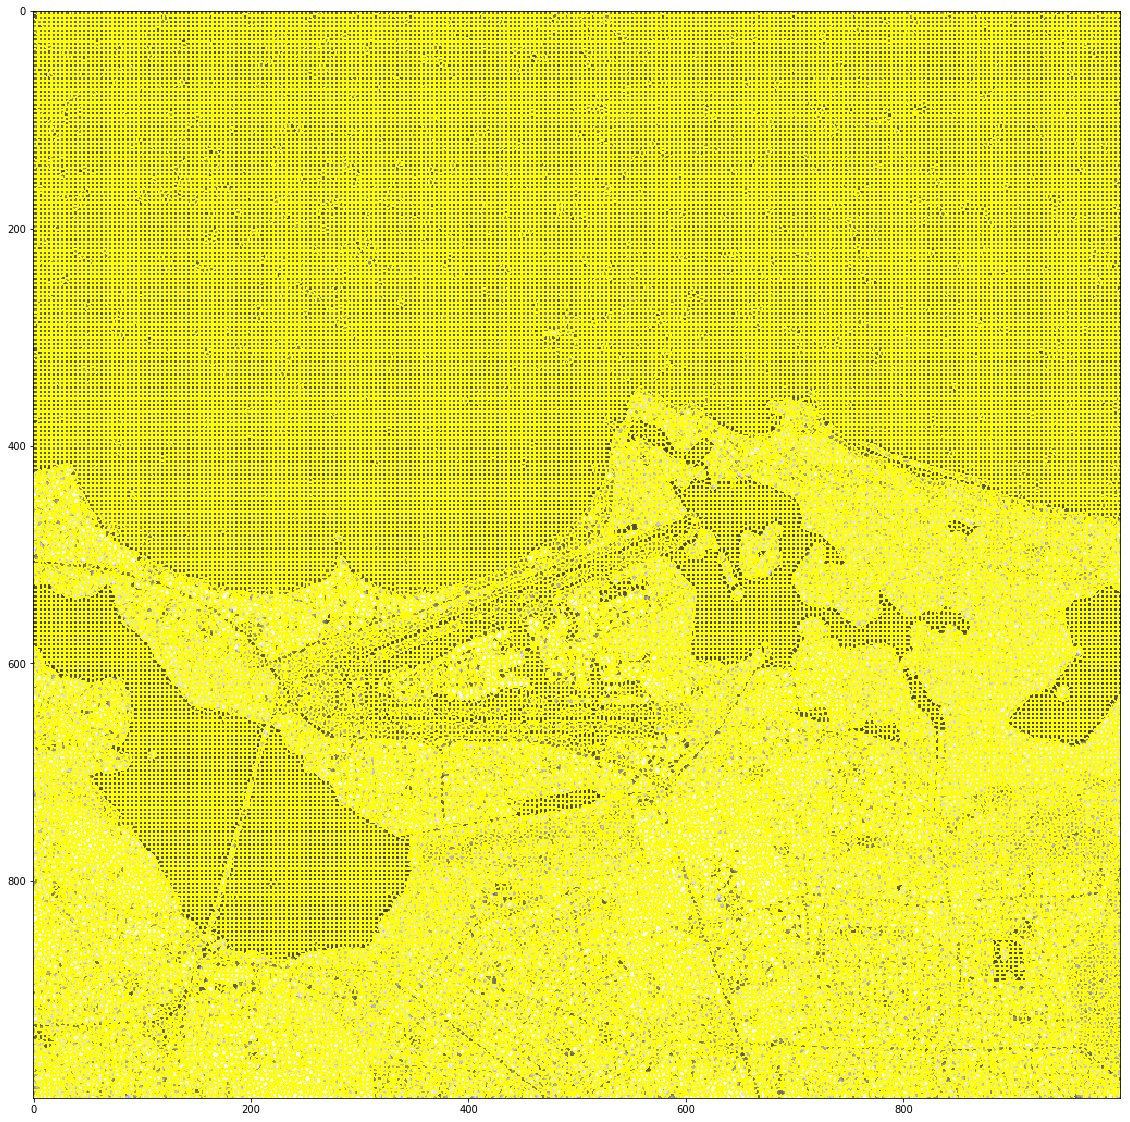

In [6]:
number_segments=50000
segments = slic(day1_training, n_segments=number_segments, compactness=50, sigma = 0,convert2lab=False)
plt.figure(figsize=(20,20))
plt.imshow(mark_boundaries(day1_training[:,:,0]/255, segments))
plt.show()

In [7]:
def calculate_segment_stats(data,segments):
    # turn the image into a 2D array (pix by channel)
    d1_flat = pd.DataFrame(np.ravel(data).reshape((-1,3)))

    # add the label vector
    d1_flat['spID'] = np.ravel(segments)

    # calculate the mean by segment
    return d1_flat.groupby('spID').mean().values

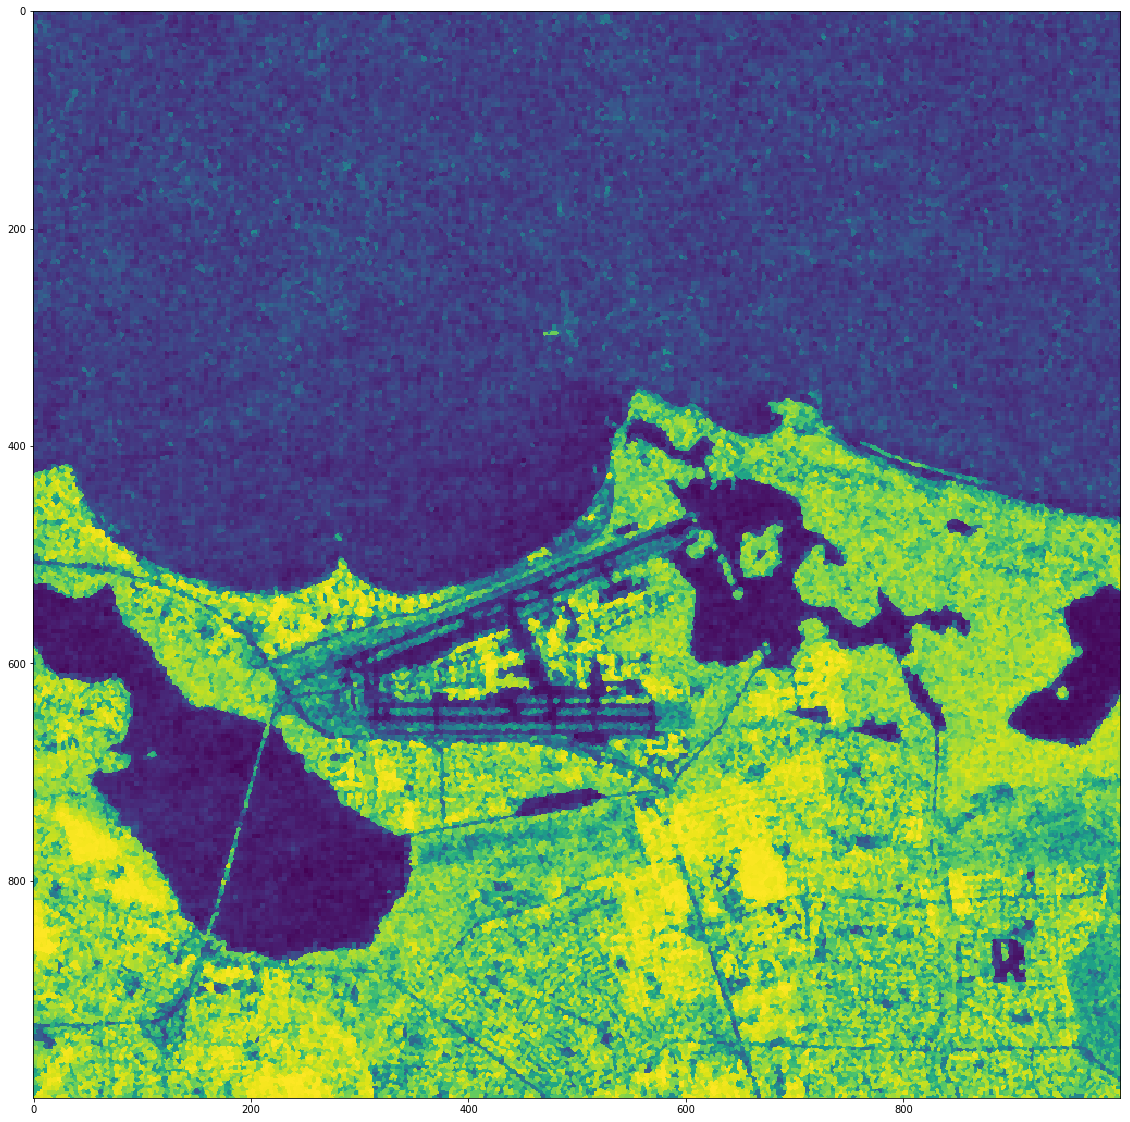

In [8]:
seg_means = calculate_segment_stats(day1_training,segments)
plt.figure(figsize=(20,20))
# broadcast the mean pixel values from the first channel
# to the same shape as the original image array
plt.imshow(seg_means[:,0][segments])

In [9]:
#from scipy import stats
#
#def calculate_segment_stats(data_array,segment_array):
#    num_segments=len(np.unique(segment_array))
#    _,_,z=np.shape(data_array)
#    features=np.zeros(6*z*num_segments)
#    features=features.reshape(num_segments,18)
#    for i in range(0,num_segments):
#        stats_list=[]
#        for band in range(0,z):
#            segment_stats=stats.describe(data_array[:,:,band][segment_array==i],axis=None)
#            stats_list = stats_list+list(segment_stats.minmax)+list(segment_stats)[2:]
#        features[i,:]=np.asarray(stats_list)
#    return features

# K-Means clustering

In this section we will apply k-means clustering to the feature set defined above. We will search for three clusters in the data. 

We will then need to apply the segment classification to every pixel in the superpixel. 

In [10]:
from sklearn import cluster,preprocessing

kmeans_3clusters=cluster.KMeans(n_clusters=4)
kmeans_3clusters.fit(seg_means)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

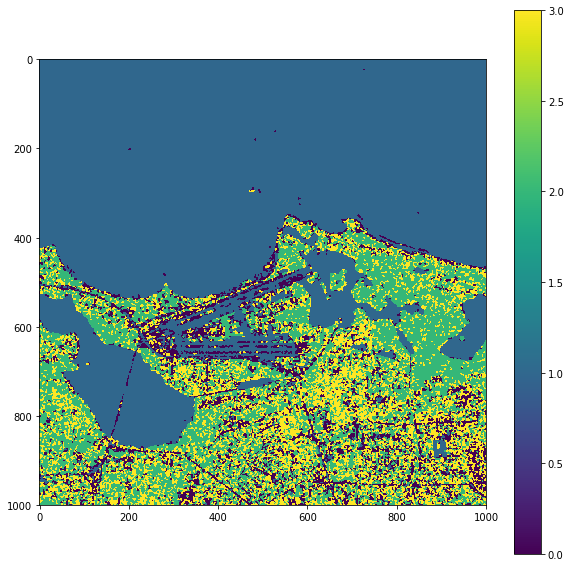

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(kmeans_3clusters.labels_[segments])
plt.colorbar()

# Detecting Flooding

From the above image we cans see that the 0 label refers to water. 

We will now define a function that will predict the labels for new pixels. We will set all clusters that are not water to 1. 


In [12]:
def predict(data, model, number_segments=number_segments):
    """ returns label image"""
    # segment the image
    test_segments = slic(data,
                         n_segments=number_segments,
                         compactness=50,
                         sigma = 0,
                         convert2lab=False)
    
    # calculate seg stats 
    test_set = calculate_segment_stats(data,test_segments)
    
    # predict
    test_set_segment_labels=model.predict(test_set)
    
    # code via broadcasting
    return test_set_segment_labels[test_segments]

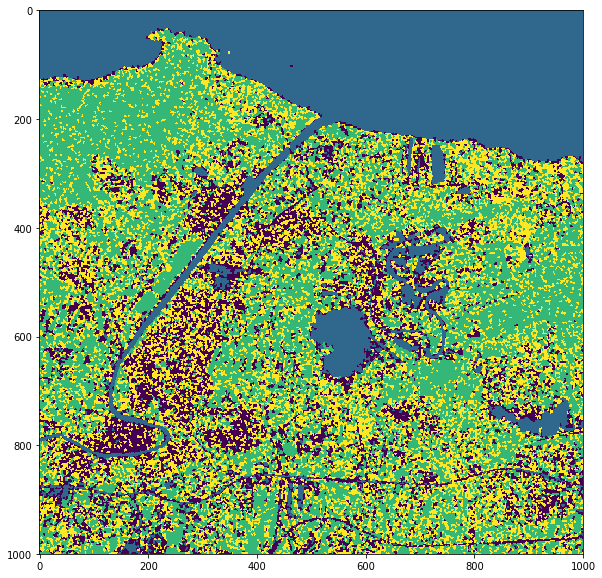

In [13]:
day1_labels=predict(day1_test,kmeans_3clusters)
plt.figure(figsize=(10,10))
plt.imshow(day1_labels)
plt.show()

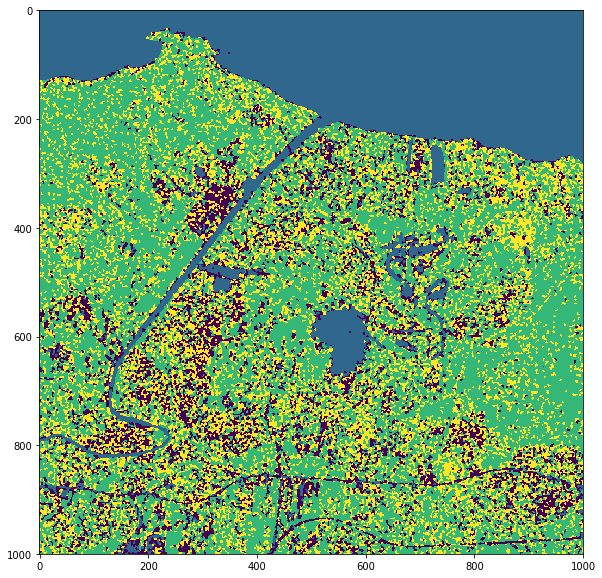

In [14]:
day2_labels=predict(day2_test,kmeans_3clusters)
plt.figure(figsize=(10,10))
plt.imshow(day2_labels)
plt.show()

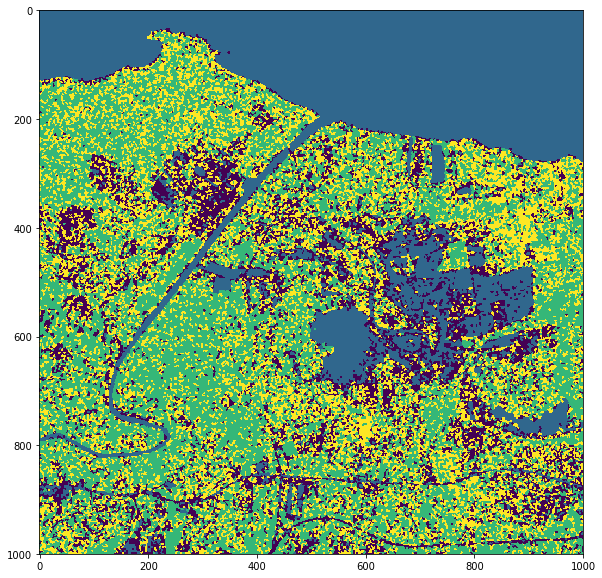

In [15]:
day3_labels=predict(day3_test,kmeans_3clusters)
plt.figure(figsize=(10,10))
plt.imshow(day3_labels)
plt.show()

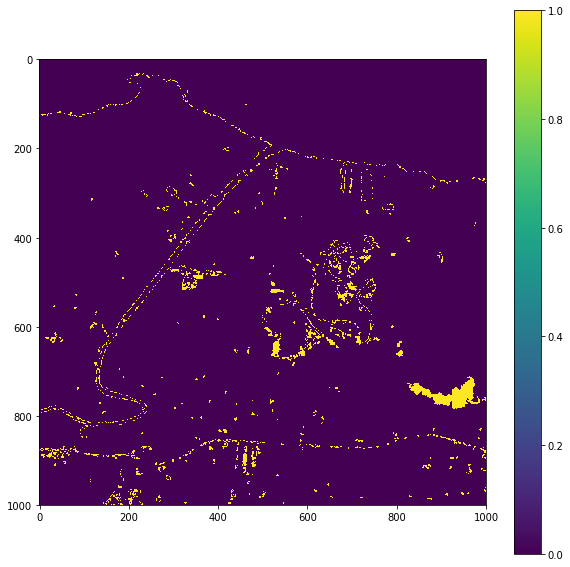

In [16]:
# water code CHANGE THIS BY HAND
wc = 1

day1_water = day1_labels==wc
day2_water = day2_labels==wc

# use exclusive or to identify areas of change
flooding = np.bitwise_xor(day1_water,day2_water)
plt.figure(figsize=(10,10))
plt.imshow(flooding)
plt.colorbar()
plt.show()